**FIRST EXAMPLE : - LQR VS LEARNING COCP**

In [ ]:
import numpy as np
import cvxpy as cp
import torch
from cvxpylayers.torch import CvxpyLayer
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm
from matplotlib.patches import Polygon
from scipy.integrate import odeint
from matplotlib.animation import FuncAnimation
# System dimensions
n = 2  # state dimension [angle, angular velocity]
m = 1  # control dimension [thrust]
# System matrices
A = np.array([[0, 1], 
              [0.5, 0]])
A = A / np.max(np.abs(np.linalg.eig(A)[0]))
B = np.array([[0], 
              [1]])
# Cost matrices
Q0 = np.array([[1, 0], 
               [0, 1]])
R0 = np.array([[1]])
# Noise parameter
noise = 0.01
W = noise**2 * np.eye(n)  # Process noise covariance
# Compute LQR solution using CVXPY
P = cp.Variable((n, n), symmetric=True)
R0cvxpy = cp.Parameter((m, m), symmetric=True)
# Objective: minimize trace(P*W)
objective = cp.trace(P @ W)
# LQR constraints
constraints = [
    cp.bmat([
        [R0cvxpy + B.T @ P @ B, B.T @ P @ A],
        [A.T @ P @ B, Q0 + A.T @ P @ A - P]
    ]) >> 0,
    P >> 0
]

# Solve the LQR problem
R0cvxpy.value = R0
prob_lqr = cp.Problem(cp.Maximize(objective), constraints)
result = prob_lqr.solve()
P_lqr = P.value
# Calculate optimal K
K_lqr = np.linalg.solve(R0 + B.T @ P_lqr @ B, B.T @ P_lqr @ A)
# Set up CVXPY policy
x = cp.Parameter((n, 1))
P_sqrt = cp.Parameter((n, n))
u = cp.Variable((m, 1))
xnext = cp.Variable((n, 1))
objective = cp.quad_form(u, R0) + cp.sum_squares(P_sqrt @ xnext)
constraints = [xnext == A @ x + B @ u]
prob = cp.Problem(cp.Minimize(objective), constraints)
policy = CvxpyLayer(prob, [x, P_sqrt], [u])
# Initialize parameters
Qt = torch.from_numpy(Q0).double()
Rt = torch.from_numpy(R0).double()
At = torch.from_numpy(A).double()
Bt = torch.from_numpy(B).double()
P_sqrt = torch.eye(n).double()
P_sqrt.requires_grad_(True)

def loss(time_horizon, batch_size, P_sqrt, seed=None):
    if seed is not None:
        torch.manual_seed(seed)
    
    total_loss = 0.0
    # Run batch_size (6) separate simulations
    for batch in range(batch_size):
        x_batch = torch.randn(1, n, 1).double()  # Single trajectory
        P_sqrt_batch = P_sqrt.reshape(1, n, n)
        Qt_batch = Qt.reshape(1, n, n)
        Rt_batch = Rt.reshape(1, m, m)
        At_batch = At.reshape(1, n, n)
        Bt_batch = Bt.reshape(1, n, m)
        
        trajectory_loss = 0.0
        for t in range(time_horizon):
            u_batch, = policy(x_batch, P_sqrt_batch, solver_args={"acceleration_lookback": 0})
            
            # Calculate costs for this timestep
            state_cost = torch.bmm(torch.bmm(Qt_batch, x_batch).transpose(2, 1), x_batch)
            control_cost = torch.bmm(torch.bmm(Rt_batch, u_batch).transpose(2, 1), u_batch)
            step_cost = state_cost.squeeze() + control_cost.squeeze()
            
            # Add to trajectory cost
            trajectory_loss += step_cost
            
            # State transition
            x_batch = torch.bmm(At_batch, x_batch) + \
                     torch.bmm(Bt_batch, u_batch) + \
                     noise * torch.randn(1, n, 1).double()
        
        # Average over time horizon for this trajectory
        trajectory_loss /= time_horizon
        total_loss += trajectory_loss
    
    # Average over all trajectories
    return total_loss / batch_size

# Compute LQR baseline loss
loss_lqr = loss(100, 6, torch.from_numpy(sqrtm(P_lqr)), seed=0).item()

# In your training loop, update to store both losses and costs:
losses = []
costs = []  # New list to store costs
optimizer = torch.optim.SGD([P_sqrt], lr=0.5)

num_iterations = 50
for k in range(num_iterations):
    # Test loss and cost calculation
    with torch.no_grad():
        test_loss = loss(100, 6, P_sqrt.detach(), seed=0).item()
        current_cost = test_loss  # Store the actual cost value
        losses.append(test_loss - loss_lqr)  # Store difference from LQR
        costs.append(current_cost)  # Store actual cost
        
        # Print iteration-wise results: LQR vs Policy Cost
        print(f"Iteration {k+1:03d}:")
        print(f"  LQR cost: {loss_lqr:.4f}")
        print(f"  Policy cost: {current_cost:.4f}")
        
        # Compute the distance between learned K and LQR K
        K_np = torch.linalg.solve(
            Rt + Bt.t() @ P_sqrt.t() @ P_sqrt @ Bt,
            -Bt.t() @ P_sqrt.t() @ P_sqrt @ At
        ).detach().numpy()
        dist = np.linalg.norm(K_np - K_lqr)
        P = (P_sqrt.t() @ P_sqrt).detach().numpy()
        dist_P = np.linalg.norm(P_lqr - P)
        print(f"  dist (K): {dist:.4f}, dist (P): {dist_P:.4f}\n")
    
    # Change learning rate halfway through
    if k == 25:
        optimizer = torch.optim.SGD([P_sqrt], lr=0.1)
    
    # Training step
    optimizer.zero_grad()
    l = loss(100, 6, P_sqrt, seed=k+1)
    l.backward()
    optimizer.step()


LQR Solution:
Optimal cost: 0.0005186665871669876
P_lqr:
[[1.39556246 0.        ]
 [0.         3.79110341]]

Optimal gain K_lqr:
[[0.55951932 0.        ]]
Iteration 001:
  LQR cost: 0.0521
  Policy cost: 0.0602
  dist (K): 0.9131, dist (P): 2.8190

Iteration 002:
  LQR cost: 0.0521
  Policy cost: 0.0595
  dist (K): 0.9190, dist (P): 2.7851

Iteration 003:
  LQR cost: 0.0521
  Policy cost: 0.0591
  dist (K): 0.9221, dist (P): 2.7673

Iteration 004:
  LQR cost: 0.0521
  Policy cost: 0.0588
  dist (K): 0.9249, dist (P): 2.7514

Iteration 005:
  LQR cost: 0.0521
  Policy cost: 0.0580
  dist (K): 0.9324, dist (P): 2.7064

Iteration 006:
  LQR cost: 0.0521
  Policy cost: 0.0578
  dist (K): 0.9355, dist (P): 2.6869

Iteration 007:
  LQR cost: 0.0521
  Policy cost: 0.0574
  dist (K): 0.9403, dist (P): 2.6578

Iteration 008:
  LQR cost: 0.0521
  Policy cost: 0.0570
  dist (K): 0.9465, dist (P): 2.6155

Iteration 009:
  LQR cost: 0.0521
  Policy cost: 0.0567
  dist (K): 0.9505, dist (P): 2.5884

**Visualization**

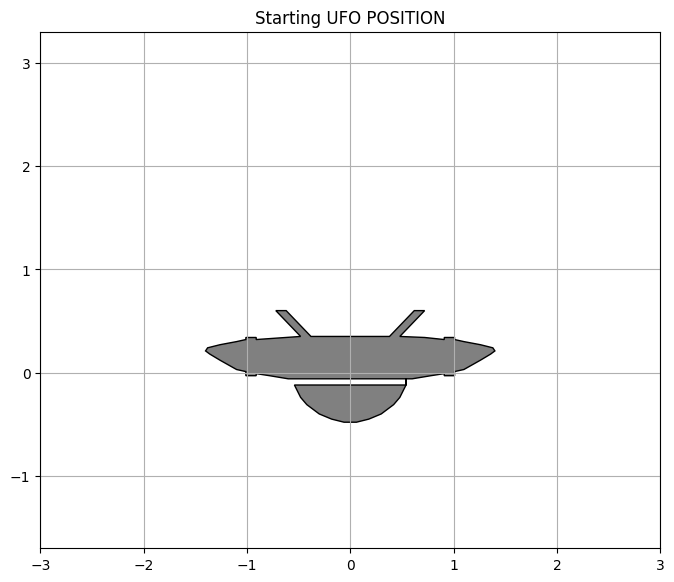

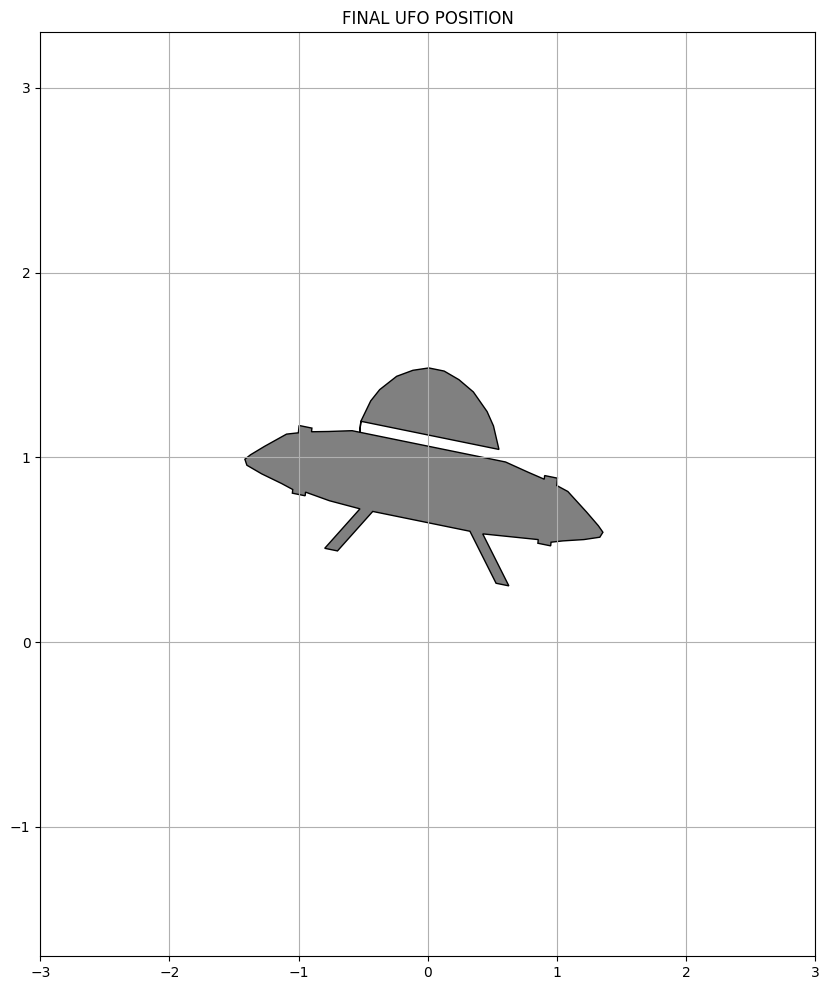

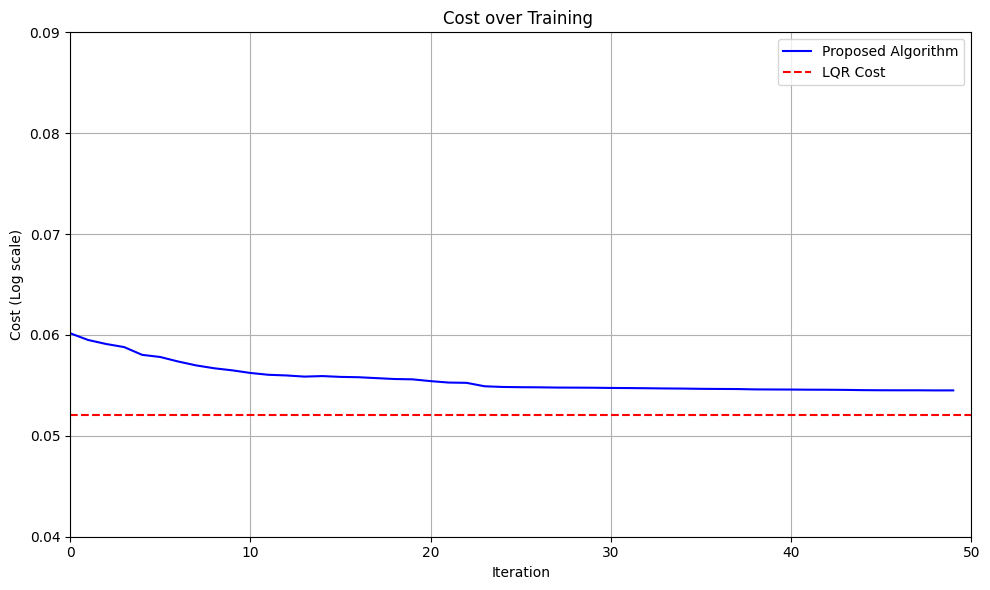

In [4]:
def rotate(data, angle):
    Q = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
    return np.dot(data, Q.T)
A_cl = A - np.dot(B, K_lqr)

# Define the dynamics and control law (LQR)
def dynamics(x, t):
    # Reshape x to be a column vector
    x = np.array(x).reshape(-1)
    # Calculate control input
    u = -np.dot(K_lqr, x)  # Remove .T since K from control.lqr is already properly shaped
    # Calculate state derivatives
    dxdt = np.dot(A_cl, x)
    return dxdt
x0 = np.array([3, 0])  # Initial state: [angle, angular velocity]
# Time vector for simulation
t = np.linspace(0, 30, 30)  # More points for smoother simulation

# Integrating the system dynamics
sol = odeint(dynamics, x0, t)

# Extract the state variables
y = sol[:, 0]  # Angle (theta)
angular_velocity = sol[:, 1]  # Angular velocity (dtheta/dt)

# Compute control inputs and fuel consumption
u_control = np.array([-np.dot(K_lqr, x) for x in sol]).flatten()
fuel_rate = np.abs(u_control)  # Fuel consumption rate
cumulative_fuel = np.cumsum(fuel_rate) * (t[1] - t[0])

ufo_data = np.array([
    [0.54, -0.12], [0.48, -0.24], [0.42, -0.31], [0.3, -0.4], [0.18, -0.45], 
    [0.06, -0.48], [-0.06, -0.48], [-0.18, -0.45], [-0.3, -0.4], [-0.42, -0.31], 
    [-0.48, -0.24], [-0.54, -0.12], [0.54, -0.12], [0.54, -0.06], [0.6, -0.06], 
    [0.78, -0.03], [0.91, -0.01], [0.91, -0.03], [1.01, -0.03], [1.01, 0.01], 
    [1.1, 0.03], [1.26, 0.12], [1.36, 0.18], [1.4, 0.21], [1.38, 0.24],
    [1.26, 0.27], [1.1, 0.3], [1.01, 0.32], [1.01, 0.34], [0.91, 0.34],
    [0.91, 0.32], [0.72, 0.34], [0.48, 0.35], [0.72, 0.6], [0.62, 0.6],
    [0.38, 0.35], [0.3, 0.35], [-0.3, 0.35], [-0.38, 0.35], [-0.62, 0.6],
    [-0.72, 0.6], [-0.48, 0.35], [-0.91, 0.32], [-0.91, 0.34], [-1.01, 0.34],
    [-1.01, 0.32], [-1.1, 0.3], [-1.26, 0.27], [-1.38, 0.24], [-1.4, 0.21],
    [-1.36, 0.18], [-1.26, 0.12], [-1.1, 0.03], [-1.01, 0.01], [-1.01, -0.03],
    [-0.91, -0.03], [-0.91, -0.01], [-0.78, -0.03], [-0.6, -0.06], [-0.54, -0.06], [0.54, -0.06]
])


# First figure: Initial position
fig1, ax = plt.subplots(figsize=(8, 8))

# Create and add the UFO polygon for initial position
ufo_poly_init = Polygon(ufo_data, fc='gray', ec='black')
ax.add_patch(ufo_poly_init)

# Set axis limits and appearance for initial position
ax.set_xlim([-3, 3])
ax.set_ylim([-1.7, 3.3])
ax.set_aspect('equal')
ax.set_title('Starting UFO POSITION')
ax.grid(True)

# Second figure: Final position and cost
fig2, ax1 = plt.subplots(1, 1, figsize=(10, 12))

# UFO final position plot
ax1.set_xlim([-3, 3])
ax1.set_ylim([-1.7, 3.3])
ax1.set_title('FINAL UFO POSITION')
ax1.grid(True)

# Create UFO polygon for final position
ufo_poly_final = Polygon(rotate(ufo_data, y[0]) + [0, 1], fc='gray', ec='black')
ax1.add_patch(ufo_poly_final)

# Third figure: Cost plot
fig3, ax2 = plt.subplots(figsize=(10, 6))
ax2.plot(np.arange(50), costs, 'b-', label='Proposed Algorithm')  # Using np.arange(50) for exact x-axis
ax2.axhline(loss_lqr, linestyle='--', color='r', label='LQR Cost')
ax2.grid(True)
ax2.set_ylim(0.04, 0.09)
ax2.set_xlim(0, 50)  # Setting x-axis limits explicitly
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Cost (Log scale)')
ax2.set_title('Cost over Training ')
ax2.legend()

def update(frame):
    ufo_rotated = rotate(ufo_data, y[frame])
    ufo_poly_final.set_xy(ufo_rotated + [0, 1])
    return ufo_poly_final,

# Create animation for final position
ani = FuncAnimation(fig2, update, frames=len(t), interval=50, blit=True)

plt.tight_layout()
plt.show()


The Algorithm creit is to be given to the original Author. The viusalization credit it to be given to: -https://github.com/aerojunkie/control-tools/blob/master/ufo_rotate.m

**Delivery Robot Estimation**


Training controller...
Iteration 10/100, Loss: 2.265
Iteration 20/100, Loss: 1.674
Iteration 30/100, Loss: 1.455
Iteration 40/100, Loss: 1.376
Iteration 50/100, Loss: 1.323
Iteration 60/100, Loss: 1.298
Iteration 70/100, Loss: 1.272
Iteration 80/100, Loss: 1.254
Iteration 90/100, Loss: 1.235
Iteration 100/100, Loss: 1.221


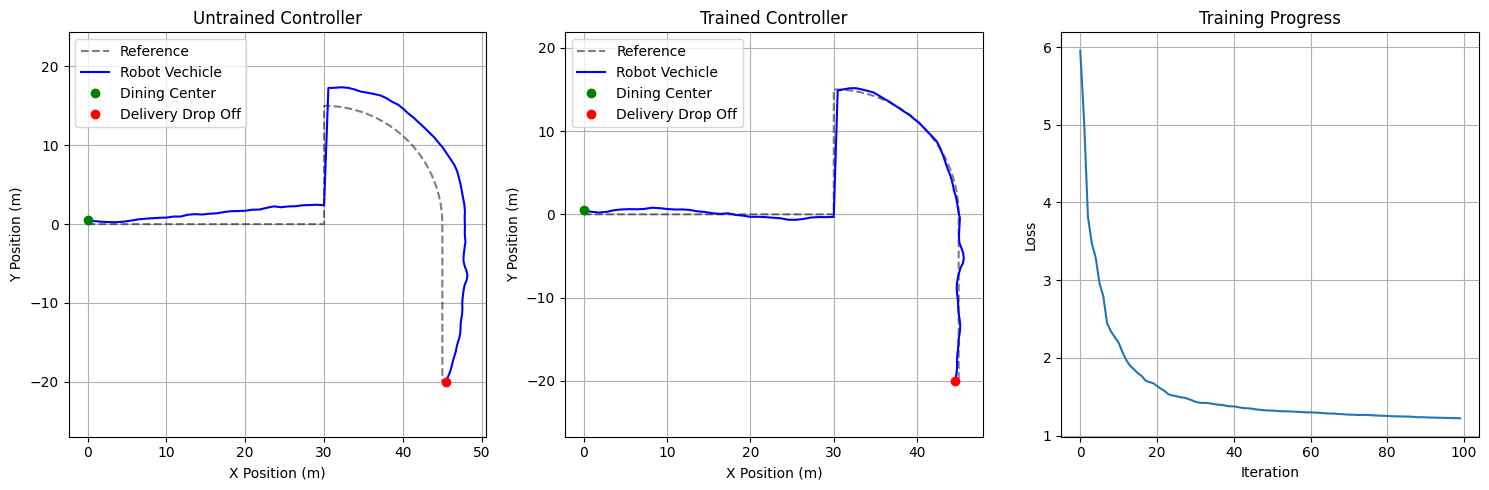

In [5]:
import torch
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
from cvxpylayers.torch import CvxpyLayer

torch.set_default_dtype(torch.double)

def generate_reference_path(n_points: int = 100) -> dict:
    """Generate reference path with proper curvature profile"""
    t = np.linspace(0, 1, n_points)
    
    # Straight section 1 (moving in +x direction)
    x1 = t * 30
    y1 = np.zeros_like(t)
    k1 = np.zeros_like(t)
    psi1 = np.zeros_like(t)  # heading = 0 (moving along +x)
    
    # Curved section (90-degree right turn)
    radius = 15
    angle = np.pi/2 * t
    x2 = x1[-1] + radius * np.cos(np.pi/2 - angle)  # adjusted for right turn
    y2 = radius * np.sin(np.pi/2 - angle)  # adjusted for right turn
    k2 = -np.ones_like(t) / radius  # negative curvature for right turn
    psi2 = -angle  # heading changes from 0 to -pi/2
    
    # Straight section 2 (moving in -y direction)
    x3 = np.ones_like(t) * x2[-1]
    y3 = y2[-1] - t * 20  # moving in -y direction
    k3 = np.zeros_like(t)
    psi3 = np.ones_like(t) * (-np.pi/2)  # heading = -pi/2 (moving along -y)
    
    # Combine segments
    x = np.concatenate([x1, x2, x3])
    y = np.concatenate([y1, y2, y3])
    curvature = np.concatenate([k1, k2, k3])
    psi = np.concatenate([psi1, psi2, psi3])
    
    path_length = np.sqrt(np.diff(x)**2 + np.diff(y)**2).sum()
    
    return {
        'x': x,
        'y': y,
        'curvature': curvature,
        'psi': psi,
        'total_length': path_length
    }

def plot_path(X, ref_path, title='Vehicle Path'):
    """Plot the vehicle path and reference path"""
    plt.plot(ref_path['x'], ref_path['y'], 'k--', label='Reference', alpha=0.5)
    
    # Calculate and plot vehicle position
    n_points = 100
    s_points = np.linspace(0, X[-1, 0], n_points)
    
    # Initialize arrays
    E_veh = np.zeros(n_points)
    N_veh = np.zeros(n_points)
    
    for i, s in enumerate(s_points):
        # Get states at current position
        path_idx = int((s / X[-1, 0]) * (len(ref_path['x']) - 1))
        path_idx = np.clip(path_idx, 0, len(ref_path['x']) - 1)
        
        # Get reference path heading and current errors
        psi_ref = ref_path['psi'][path_idx]
        e = np.interp(s, X[:, 0], X[:, 1])  # lateral error
        
        # Calculate vehicle position relative to reference path
        E_veh[i] = ref_path['x'][path_idx] - e * np.sin(psi_ref)
        N_veh[i] = ref_path['y'][path_idx] + e * np.cos(psi_ref)
    
    plt.plot(E_veh, N_veh, 'b-', label='Robot Vechicle')
    plt.plot(E_veh[0], N_veh[0], 'go', label='Dining Center')
    plt.plot(E_veh[-1], N_veh[-1], 'ro', label='Delivery Drop Off')
    
    # Adjust plot limits
    max_range = max(
        np.max(ref_path['x']) - np.min(ref_path['x']),
        np.max(ref_path['y']) - np.min(ref_path['y'])
    ) + 5
    
    center_x = np.mean([np.min(ref_path['x']), np.max(ref_path['x'])])
    center_y = np.mean([np.min(ref_path['y']), np.max(ref_path['y'])])
    
    plt.xlim(center_x - max_range/2, center_x + max_range/2)
    plt.ylim(center_y - max_range/2, center_y + max_range/2)
    plt.grid(True)
    plt.xlabel('X Position (m)')
    plt.ylabel('Y Position (m)')
    plt.title(title)
    plt.legend()
    plt.axis('equal')

# The rest of the code (EnhancedVehicleController class and compare_policies function) 
# remains exactly the same
class EnhancedVehicleController:
    def __init__(self):
        self.L = 2.8  # vehicle wheelbase
        self.h = 0.2  # timestep
        self.n = 6    # state dimension
        self.m = 2    # control dimension
        
        # Cost weights
        self.lam_1 = 1.0   # lateral error cost
        self.lam_2 = 1.0   # heading error cost
        self.lam_3 = 10.0  # acceleration cost
        self.lam_4 = 10.0  # steering cost
        
        # Generate and store reference path
        self.reference_path = generate_reference_path()
        
        # Initialize control parameters
        self.setup_cvx_problem()
        self.P_sqrt = torch.eye(4, requires_grad=True)
        self.q = torch.zeros(4, requires_grad=True)
    
    def setup_cvx_problem(self):
        """Setup the CVX optimization problem"""
        self.P_sqrt_param = cp.Parameter((4, 4))
        self.q_param = cp.Parameter(4)
        self.fx_param = cp.Parameter(4)
        self.B_param = cp.Parameter((4, 2))
        self.curvature_param = cp.Parameter(1)
        
        u = cp.Variable(2)
        y = cp.Variable(4)
        
        objective = (self.lam_3 * cp.square(u[0]) + self.lam_4 * cp.square(u[1]) + 
                    cp.sum_squares(self.P_sqrt_param @ y) + self.q_param @ y)
        
        constraints = [
            y == self.fx_param + self.B_param @ u,
            cp.abs(u[0]) <= 2,  # acceleration limits
            cp.abs(u[1] + self.L * self.curvature_param) <= 0.68  # steering limits
        ]
        
        prob = cp.Problem(cp.Minimize(objective), constraints)
        self.policy = CvxpyLayer(prob, [self.P_sqrt_param, self.q_param, self.fx_param, 
                                      self.B_param, self.curvature_param], [u])
    
    def dynamics(self, x: torch.Tensor, u: torch.Tensor) -> torch.Tensor:
        """Compute next state with reference path tracking"""
        batch_size = x.shape[0]
        s, e, dpsi, v, vdes, curvature = torch.split(x, 1, dim=1)
        a, z = torch.split(u, 1, dim=1)
        
        # Get reference curvature
        path_length = len(self.reference_path['curvature'])
        s_np = s.detach().cpu().numpy()
        path_idx = (s_np * path_length / self.reference_path['total_length']).astype(int)
        path_idx = np.clip(path_idx, 0, path_length - 1)
        reference_curvature = torch.tensor(self.reference_path['curvature'][path_idx], 
                                         requires_grad=True)
        
        # Update curvature to track reference
        curvature_next = 0.95 * curvature + 0.05 * reference_curvature
        
        # Random velocity changes
        vdes_to_not_change = torch.rand(batch_size, 1) < 0.98
        vdes_next = torch.where(
            vdes_to_not_change,
            vdes,
            3 + 3 * torch.rand_like(vdes)
        )
        
        # State update
        xnext = torch.cat([
            s + self.h * v / (1 - e * curvature) * torch.cos(dpsi),
            e + self.h * v * torch.sin(dpsi),
            dpsi + self.h * v * (curvature + z / self.L - 
                                curvature / (1 - e * curvature) * torch.cos(dpsi)),
            v + self.h * a,
            vdes_next,
            curvature_next
        ], dim=1)
        
        # Add noise
        xnext[:, 1] += 1e-1 * torch.randn(batch_size, 1).squeeze()  # lateral error noise
        xnext[:, 2] += 1e-2 * torch.randn(batch_size, 1).squeeze()  # heading error noise
        xnext[:, 3] += 1e-1 * torch.randn(batch_size, 1).squeeze()  # velocity noise
        
        return xnext
    
    def cost(self, x: torch.Tensor, u: torch.Tensor) -> torch.Tensor:
        """Compute stage cost"""
        s, e, dpsi, v, vdes, curvature = torch.split(x, 1, dim=1)
        a, z = torch.split(u, 1, dim=1)
        
        return ((v - vdes).pow(2) + 
                self.lam_1 * e.pow(2) + 
                self.lam_2 * dpsi.pow(2) + 
                self.lam_3 * a.pow(2) + 
                self.lam_4 * z.pow(2))
    
    def get_control(self, x: torch.Tensor) -> torch.Tensor:
        """Compute control input"""
        s, e, dpsi, v, vdes, curvature = torch.split(x, 1, dim=1)
        
        enext = e + self.h * v * torch.sin(dpsi)
        dpsi_next = dpsi + self.h * v * (curvature - 
                                        curvature / (1 - e * curvature) * torch.cos(dpsi))
        
        fx = torch.cat([
            enext,
            dpsi_next,
            v - 0.98 * vdes - 0.02 * 4.5,
            enext + self.h * v * torch.sin(dpsi_next)
        ], dim=1)
        
        batch_size = x.shape[0]
        B = torch.zeros(batch_size, 4, 2)
        B[:, 1, 1] = self.h * v.squeeze() / self.L
        B[:, 2, 0] = self.h
        B[:, 3, 1] = self.h * self.h * v.squeeze() * v.squeeze() / self.L
        
        u, = self.policy(self.P_sqrt, self.q, fx, B, curvature)
        return u
    
    def simulate_trajectory(self, time_horizon: int, batch_size: int, 
                          P_sqrt: torch.Tensor = None, q: torch.Tensor = None,
                          seed: int = None) -> tuple:
        """Simulate system trajectory"""
        if seed is not None:
            torch.manual_seed(seed)
            
        P_sqrt = self.P_sqrt if P_sqrt is None else P_sqrt
        q = self.q if q is None else q
            
        X, U = [], []
        x = torch.zeros(batch_size, self.n)
        x[:, 1] = 0.5  # initial lateral error
        x[:, 2] = 0.1  # initial heading error
        x[:, 3] = 3.0  # initial velocity
        x[:, 4] = 4.5  # initial desired velocity
        
        loss = 0.0
        for t in range(time_horizon):
            u = self.get_control(x)
            X.append(x[0].detach().numpy())
            U.append(u[0].detach().numpy())
            loss += self.cost(x, u).mean() / time_horizon
            x = self.dynamics(x, u)
            
        return loss, np.array(X), np.array(U)
    
    def train(self, n_iterations: int, time_horizon: int, batch_size: int) -> list:
        """Train using projected SGD"""
        optimizer = torch.optim.SGD([self.P_sqrt, self.q], lr=0.1)
        losses = []
        
        for k in range(n_iterations):
            # Training step
            optimizer.zero_grad()
            loss, _, _ = self.simulate_trajectory(time_horizon, batch_size, seed=k+1)
            loss.backward()
            
            # Gradient clipping (projection)
            torch.nn.utils.clip_grad_norm_([self.P_sqrt, self.q], 10)
            optimizer.step()
            
            # Evaluation
            with torch.no_grad():
                test_loss, _, _ = self.simulate_trajectory(time_horizon, batch_size, seed=0)
                losses.append(test_loss.item())
                if (k + 1) % 10 == 0:
                    print(f"Iteration {k+1}/{n_iterations}, Loss: {test_loss:.3f}")
        
        return losses

def compare_policies():
    """Compare untrained and trained policies"""
    controller = EnhancedVehicleController()
    time_horizon = 100
    batch_size = 1
    
    # Untrained policy
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    _, X_untrained, _ = controller.simulate_trajectory(
        time_horizon=time_horizon,
        batch_size=batch_size,
        P_sqrt=torch.eye(4),
        q=torch.zeros(4),
        seed=0
    )
    plot_path(X_untrained, controller.reference_path, 'Untrained Controller')
    
    # Train controller
    print("\nTraining controller...")
    losses = controller.train(n_iterations=100, time_horizon=time_horizon, batch_size=32)
    
    # Trained policy l
    plt.subplot(1, 3, 2)
    _, X_trained, _ = controller.simulate_trajectory(
        time_horizon=time_horizon,
        batch_size=batch_size,
        seed=0
    )
    plot_path(X_trained, controller.reference_path, 'Trained Controller')
    
    # Training losses
    plt.subplot(1, 3, 3)
    plt.plot(losses)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Training Progress')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()


def main():
    torch.manual_seed(0)
    np.random.seed(0)
    
    controller = EnhancedVehicleController()
    time_horizon = 100
    
    # Plot untrained trajectory
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    _, X_untrained, _ = controller.simulate_trajectory(
        time_horizon=time_horizon,
        batch_size=1,
        P_sqrt=torch.eye(4),
        q=torch.zeros(4),
        seed=0
    )
    plot_path(X_untrained, controller.reference_path, 'Untrained Controller')
    
    # Train controller
    print("\nTraining controller...")
    losses = controller.train(n_iterations=100, time_horizon=time_horizon, batch_size=4)
    
    # Plot trained trajectory
    plt.subplot(1, 3, 2)
    _, X_trained, _ = controller.simulate_trajectory(
        time_horizon=time_horizon,
        batch_size=1,
        seed=0
    )
    plot_path(X_trained, controller.reference_path, 'Trained Controller')
    
    # Plot losses
    plt.subplot(1, 3, 3)
    plt.plot(losses)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Training Progress')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

The Algorithm Credit has to be given to the Original Paper Author but the path has been randomly generated

**SPACE CRAFT LANDING**

Solving original optimization...

Training learnable version...
Epoch 0, Loss: 20.5562, LR: 0.010000
Epoch 10, Loss: 20.3497, LR: 0.009500
Epoch 20, Loss: 20.3265, LR: 0.009025
Epoch 30, Loss: 20.4786, LR: 0.008574
Epoch 40, Loss: 20.3600, LR: 0.008145
Early stopping at epoch 42

Plotting comparison...


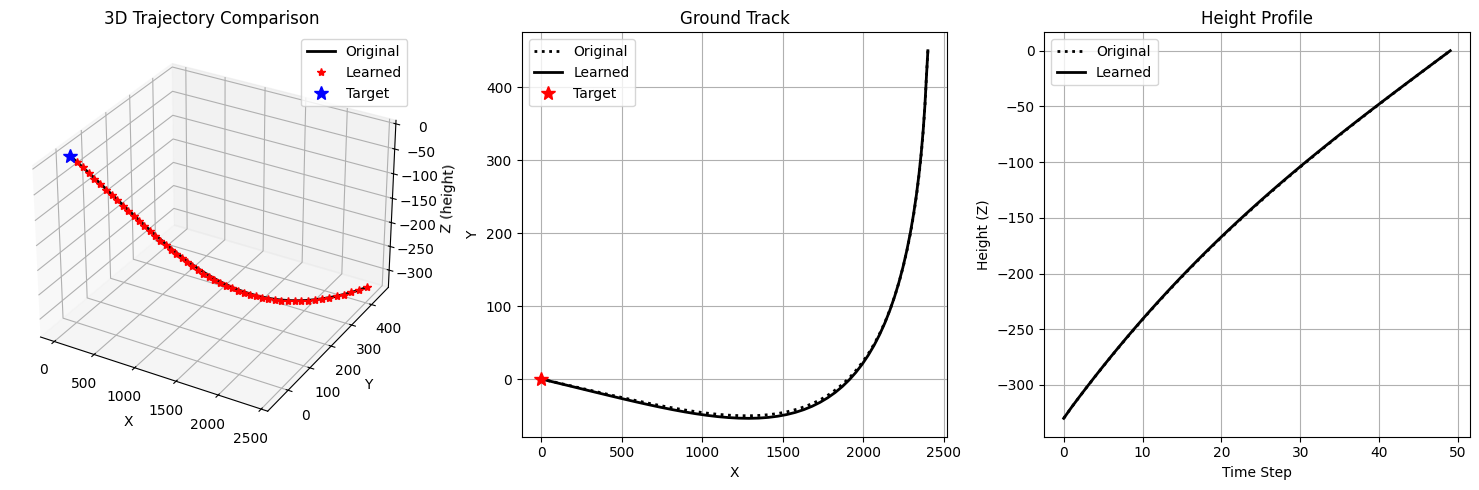


Final learned parameters:
[1.         0.10000923 0.10000214]


In [ ]:

import numpy as np
import cvxpy as cp
import torch
import cvxpylayers.torch as cvxl
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

# Initial state and parameters
x0 = np.array([2400, 450, -330, -10, -40, 10]).T  # [r, ṙ].T
q = np.array([0, 0])      # target coordinates

# Mass parameters
m0 = 2000               # initial mass (kg)
mf = 300                # fuel mass (kg)
alpha = 5e-4            # fuel consumption rate (s/m)

# Thrust parameters
Tmax = 24000            # max thrust (N)
rho1 = 0.2 * Tmax       # lower bound thrust (N)
rho2 = 0.8 * Tmax       # upper bound thrust (N)

# Simulation time
tf = 50                 # end time (s)
dt = 1                  # time interval (s)
N = int(tf / dt)

# Mass logs
zi = np.log(m0)
zf = np.log(m0 - mf)

# Angles and constraints
glide_slope_angle = 30
gamma_tan = np.tan(np.deg2rad(glide_slope_angle))
theta_deg = 120
theta_cos = np.cos(np.deg2rad(theta_deg))
velocity_max = 90

# Planet parameters
omega = np.array([2.53e-5, 0, 6.62e-5]).T     # rotation angular velocity
g = np.array([-3.71, 0, 0]).T                 # gravitational acceleration

# Unit vectors and matrices
e1 = np.array([1,0,0]).T
e2 = np.array([0,1,0]).T
e3 = np.array([0,0,1]).T
E = np.array([e2.T, e3.T])

# System matrices
S = np.array([[0, -omega[2], omega[1]], 
              [omega[2], 0, -omega[0]], 
              [omega[1], omega[0], 0]])
A = np.block([[np.zeros((3, 3)), np.eye(3)], 
              [-S**2, -2*S]])
B = np.block([[np.zeros((3, 3))], [np.eye(3)]])

def set_constraints(constraints, x, z, u, gamma):
    """Set common constraints for both original problems"""
    # Boundary constraints
    constraints.append(x[:,0] == x0)
    constraints.append(z[0,0] == zi)
    constraints.append(z[0,N-1] >= zf)
    constraints.append(e1.T @ x[:3,N-1] == 0)
    constraints.append(e1.T @ x[3:,N-1] == 0)
    
    constraints.append(cp.norm(x[3:6,N-1]) <= velocity_max)
    
    # Dynamic constraints
    for t in range(N-1):
        constraints.append(x[:,t+1] == x[:,t] + (A @ x[:,t] + B @ (g+u[:,t])) * dt)
        constraints.append(z[:,t+1] == z[:,t] - alpha * gamma[:,t])

    # Thrust constraints
    constraints.append(cp.norm(u, axis=0) <= gamma[0,:])
    constraints.append(e1 @ u >= gamma[0,:] * theta_cos)
    
    # Mass and slack variable constraints
    z0 = np.zeros((1, N))
    z0[0] = [np.log(m0 - alpha * rho2 * dt * i) for i in range(N)]
    constraints.append(rho1 * np.exp(-zi) * (1-(z[0,:] - z0[0,:]) + 
                                           (z[0,:] - z0[0,:])**2/2) <= gamma[0,:])
    
    # Glide slope constraint
    constraints.append(x[0,:] >= (cp.norm(x[1:3], axis=0) * gamma_tan))
    
    return constraints

def solve_minimum_err(dt, N, x0):
    """Solve minimum landing error problem"""
    x = cp.Variable((6, N))      # [pos(3), vel(3)]
    z = cp.Variable((1, N))      # ln(m)
    u = cp.Variable((3, N))      # thrust
    gamma = cp.Variable((1, N))  # slack variable
    
    objective = cp.Minimize(cp.norm(E @ x[:3,N-1] - q))
    constraints = []
    constraints = set_constraints(constraints, x, z, u, gamma)
    
    problem = cp.Problem(objective, constraints)
    problem.solve()
    return problem.status, x, u

def solve_fuel_opt(dt, N, x0, dP3):
    """Solve minimum fuel problem"""
    x = cp.Variable((6, N))
    z = cp.Variable((1, N))
    u = cp.Variable((3, N))
    gamma = cp.Variable((1, N))
    
    objective = cp.Minimize(cp.sum(gamma) * dt)
    constraints = []
    constraints = set_constraints(constraints, x, z, u, gamma)
    constraints.append(cp.norm(E @ x[:3,N-1] - q) <= dP3)
    
    problem = cp.Problem(objective, constraints)
    problem.solve()
    return problem.status, x, u

class LearnableLanding:
    def __init__(self):
        self.theta = torch.nn.Parameter(torch.tensor([1.0, 0.1, 0.1]))
        self.best_loss = float('inf')
        self.best_theta = self.theta.data.clone()
        
    def create_layer(self):
        """Create learnable optimization layer"""
        x = cp.Variable((6, N))
        z = cp.Variable((1, N))
        u = cp.Variable((3, N))
        gamma = cp.Variable((1, N))
        
        weights = cp.Parameter(3, nonneg=True)
        
        objective = cp.Minimize(
            weights[0] * cp.norm(E @ x[:3,N-1] - q) +
            weights[1] * cp.sum(gamma) * dt +
            weights[2] * cp.sum([cp.norm(u[:,t]) for t in range(N)])
        )
        
        constraints = set_constraints([], x, z, u, gamma)
        
        return cvxl.CvxpyLayer(
            cp.Problem(objective, constraints),
            parameters=[weights],
            variables=[x, z, u, gamma]
        )
    def train(self, num_epochs=100, learning_rate=0.01):
        """Train the landing policy with stable loss reduction"""
        layer = self.create_layer()
        optimizer = torch.optim.Adam([self.theta], lr=learning_rate)
        
        # Add gradient clipping
        torch.nn.utils.clip_grad_norm_([self.theta], max_norm=1.0)
        
        losses = []
        no_improve_count = 0
        
        for epoch in range(num_epochs):
            optimizer.zero_grad()
            
            try:
                current_lr = learning_rate * (0.95 ** (epoch // 10))  # Learning rate decay
                for param_group in optimizer.param_groups:
                    param_group['lr'] = current_lr
                    
                x, z, u, gamma = layer(self.theta)
                
                landing_error = torch.norm(x[:2,-1] - torch.tensor(q, dtype=torch.float32))
                fuel_cost = torch.sum(gamma) * dt
                
                loss = landing_error + 0.1 * fuel_cost
                
                # Line search with backtracking
                current_theta = self.theta.data.clone()
                loss.backward()
                
                # Try different step sizes
                step_size = current_lr
                min_loss = loss.item()
                best_step = step_size
                
                for _ in range(5):  # Try 5 different step sizes
                    optimizer.step()
                    with torch.no_grad():
                        x_new, z_new, u_new, gamma_new = layer(self.theta)
                        new_loss = (torch.norm(x_new[:2,-1] - torch.tensor(q, dtype=torch.float32)) + 
                                  0.1 * torch.sum(gamma_new) * dt)
                        
                        if new_loss < min_loss:
                            min_loss = new_loss.item()
                            best_step = step_size
                        
                        step_size *= 0.5
                        self.theta.data = current_theta - best_step * self.theta.grad
                
                # Update with best step size
                self.theta.data = current_theta - best_step * self.theta.grad
                
                # Keep track of best parameters
                if min_loss < self.best_loss:
                    self.best_loss = min_loss
                    self.best_theta = self.theta.data.clone()
                    no_improve_count = 0
                else:
                    no_improve_count += 1
                
                # Early stopping if no improvement
                if no_improve_count > 20:
                    print(f"Early stopping at epoch {epoch}")
                    break
                
                losses.append(min_loss)
                
                if epoch % 10 == 0:
                    print(f"Epoch {epoch}, Loss: {min_loss:.4f}, LR: {current_lr:.6f}")
                    
            except Exception as e:
                print(f"Error in epoch {epoch}: {str(e)}")
                continue
        
        # Use best found parameters
        self.theta.data = self.best_theta
        return layer(self.theta)[0]  # Return final trajectory



def plot_comparison(orig_x, learned_x):
    """Plot comparison with black colors"""
    fig = plt.figure(figsize=(15, 5))
    
    # 3D trajectory
    ax1 = fig.add_subplot(131, projection='3d')
    
    # Original trajectory (black dotted)
    X_orig, Y_orig, Z_orig = orig_x.value.T[:,:3].T
    ax1.plot(X_orig, Y_orig, Z_orig, 'k-', label='Original', linewidth=2)
    
    # Learned trajectory (black solid)
    X_learned = learned_x.detach().numpy()
    ax1.plot(X_learned[0], X_learned[1], X_learned[2], 'r*', 
             label='Learned', linewidth=2)
    
    # Target point
    ax1.plot([q[0]], [q[1]], [0], 'b*', markersize=10, label='Target')
    
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z (height)')
    ax1.legend()
    ax1.set_title('3D Trajectory Comparison')
    
    # Ground plane projection
    ax2 = fig.add_subplot(132)
    ax2.plot(X_orig, Y_orig, 'k:', label='Original', linewidth=2)
    ax2.plot(X_learned[0], X_learned[1], 'k-', label='Learned', linewidth=2)
    ax2.plot(q[0], q[1], 'r*', markersize=10, label='Target')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.grid(True)
    ax2.legend()
    ax2.set_title('Ground Track')
    
    # Height profile
    ax3 = fig.add_subplot(133)
    time_steps = np.arange(len(Z_orig))
    ax3.plot(time_steps, Z_orig, 'k:', label='Original', linewidth=2)
    ax3.plot(time_steps, X_learned[2], 'k-', label='Learned', linewidth=2)
    ax3.set_xlabel('Time Step')
    ax3.set_ylabel('Height (Z)')
    ax3.grid(True)
    ax3.legend()
    ax3.set_title('Height Profile')
    
    plt.tight_layout()
    plt.show()

def main():
    # Solve original optimization
    print("Solving original optimization...")
    status, x, u = solve_minimum_err(dt, N, x0)
    if status != "optimal":
        print("Original solution not optimal")
        return
    
    dP3 = x.value[1:3, N-1]
    status, x_fuel, u_fuel = solve_fuel_opt(dt, N, x0, dP3)
    
    # Solve learnable version
    print("\nTraining learnable version...")
    landing = LearnableLanding()
    learned_x = landing.train()
    
    # Plot comparison
    print("\nPlotting comparison...")
    plot_comparison(x_fuel, learned_x)
    
    print("\nFinal learned parameters:")
    print(landing.theta.detach().numpy())

def plot_comparison(orig_x, learned_x):
    """Plot comparison with black colors"""
    fig = plt.figure(figsize=(15, 5))
    
    # 3D trajectory
    ax1 = fig.add_subplot(131, projection='3d')
    
    # Original trajectory (black dotted)
    X_orig, Y_orig, Z_orig = orig_x.value.T[:,:3].T
    ax1.plot(X_orig, Y_orig, Z_orig, 'k-', label='Original', linewidth=2)
    
    # Learned trajectory (black solid)
    X_learned = learned_x.detach().numpy()
    ax1.plot(X_learned[0], X_learned[1], X_learned[2], 'r*', 
             label='Learned', linewidth=2)
    
    # Target point
    ax1.plot([q[0]], [q[1]], [0], 'r*', markersize=10, label='Target')
    
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z (height)')
    ax1.legend()
    ax1.set_title('3D Trajectory Comparison')
    
    # Ground plane projection
    ax2 = fig.add_subplot(132)
    ax2.plot(X_orig, Y_orig, 'k:', label='Original', linewidth=2)
    ax2.plot(X_learned[0], X_learned[1], 'k-', label='Learned', linewidth=2)
    ax2.plot(q[0], q[1], 'r*', markersize=10, label='Target')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.grid(True)
    ax2.legend()
    ax2.set_title('Ground Track')
    
    # Height profile
    ax3 = fig.add_subplot(133)
    time_steps = np.arange(len(Z_orig))
    ax3.plot(time_steps, Z_orig, 'k:', label='Original', linewidth=2)
    ax3.plot(time_steps, X_learned[2], 'k-', label='Learned', linewidth=2)
    ax3.set_xlabel('Time Step')
    ax3.set_ylabel('Height (Z)')
    ax3.grid(True)
    ax3.legend()
    ax3.set_title('Height Profile')
    
    plt.tight_layout()
    plt.show()
    
if __name__ == "__main__":
    main()

The Code for the one which doesnt consider COCP is https://github.com/ravi4ram/Soft-Landing-Optimizer/blob/master/soft_landing_optimizer.py, the COCP code had to be implemnted has its new.